# Plotting with Atlite

This little notebook creates all the plots given in the introduction section. Geographical plotting with Atlite can be efficiently and straightfowardly done when relying on some well maintained python packages. In particular a good rule of thumb is following. When it comes to 

* **projections and transformation** &rightarrow; ask [Cartopy](https://pypi.org/project/Cartopy/)
* **plotting shapes** &rightarrow; ask [GeoPandas](http://geopandas.org/)
* **plotting data on geographical grids** or **time series** &rightarrow; ask [xarray](http://xarray.pydata.org/en/stable/)

Since they interact well together, one has just to consider some essential commands. 
So, let's dive into the code!

First of all import all relevant packages 

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

*Note: `geopandas` will also require the `descartes` package to be installed.*

## Create shapes for United Kingdom and Ireland

* use the shapereader of Cartopy to retrieve high resoluted shapes
* make a GeoSeries with the shapes

In [2]:
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
UkIr = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Ireland'])

## Create the cutout

* create a cutout with geographical bounds of the shapes

Here we use the data from ERA5 from UK and Ireland in January of 2011.

In [3]:
# Define the cutout; this will not yet trigger any major operations
cutout = atlite.Cutout(path="uk-2011-01",
                       module="era5",
                       bounds=UkIr.unary_union.bounds,
                       time="2011-01")

# This is where all the work happens (this can take some time, for us it took ~15 minutes).
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "uk-2011-01">
 x = -13.50 ⟷ 1.75, dx = 0.25
 y = 50.00 ⟷ 60.75, dy = 0.25
 time = 2011-01-01 ⟷ 2011-01-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

## Define a overall projection 

This projection will be used throughout the following plots.
It has to be assigned to every axis that should be based on this projection

In [4]:
projection = ccrs.Orthographic(-10, 35)

## Plotting

### Plot Earth with cutout bound
* create GeoSeries with cell relevant data
* plot 'naturalearth_lowres' (country shapes) with unary union of cells on top

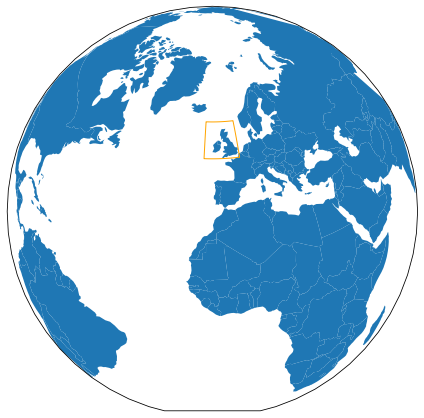

In [5]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(-10, 35)
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
fig.tight_layout()

### Plot the cutout's raw data
* create matplotlib [GridSpec](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.gridspec.GridSpec.html#matplotlib.gridspec.GridSpec)
* country shapes and cells on left hand side
* time series for `wind100m`, `influx_direct`, `runoff` on right hand side

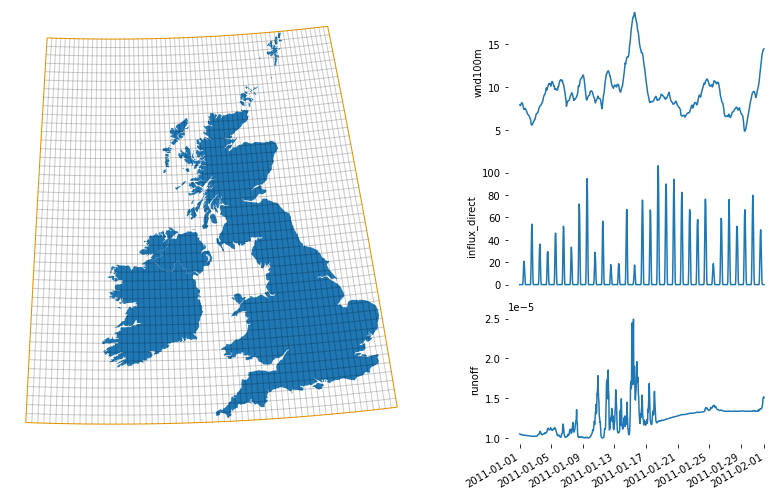

In [6]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())
UkIr.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
ax.outline_patch.set_edgecolor('white')

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(['x', 'y']).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()

### Plot capacity factors

* calculate the mean capacity factors for each cell for a selected turbine (e.g. Vestas V112 3MW)
* use xarray plotting function to directly plot data
* plot cells GeoSeries on top

INFO:atlite.convert:Convert and aggregate 'wind'.


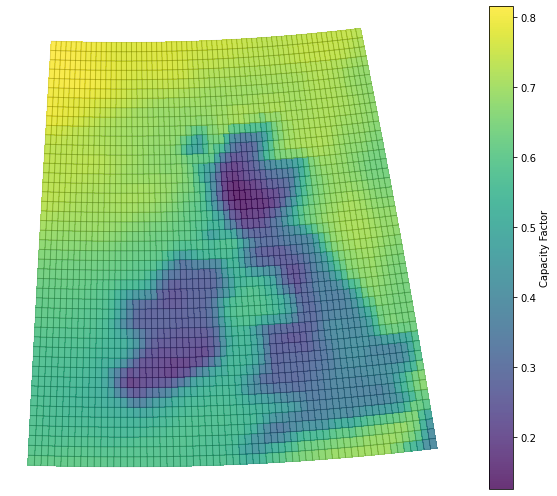

In [7]:
cap_factors = cutout.wind(turbine='Vestas_V112_3MW', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

### Plot power generation for selected areas

* First define a capacity layout, defining on which sites to install how much turbine capacity
* Generate the power generation time series for the selected sites

INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


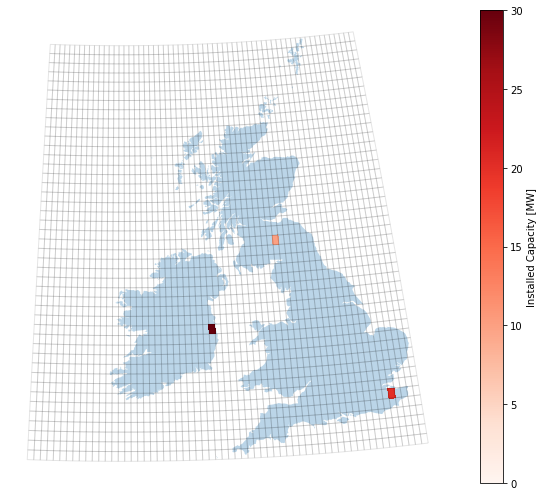

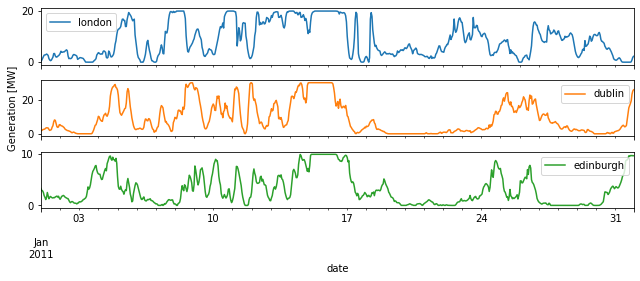

In [8]:
sites = gpd.GeoDataFrame([['london', 0.7, 51.3, 20],
                          ['dublin', -6.16, 53.21, 30],
                          ['edinburgh', -3.13, 55.5, 10]],
                         columns=['name', 'x', 'y', 'capacity']
                         ).set_index('name')

nearest = cutout.data.sel(
    {'x': sites.x.values, 'y': sites.y.values}, 'nearest').coords
sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values
cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))

UkIr.plot(ax=ax, zorder=1, transform=plate(), alpha=0.3)
cells.plot(ax=ax, **plot_grid_dict)
layout.plot(ax=ax, transform=plate(), cmap='Reds', vmin=0,
            label='Installed Capacity [MW]')
ax.outline_patch.set_edgecolor('white')
fig.tight_layout()

fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))
power_generation = cutout.wind('Vestas_V112_3MW', layout=layout,
                               shapes=cells_generation.geometry)

power_generation.to_pandas().plot(subplots=True, ax=axes)
axes[2].set_xlabel('date')
axes[1].set_ylabel('Generation [MW]')
fig.tight_layout()

### Aggregate power generation per country shape

INFO:atlite.convert:Convert and aggregate 'wind'.


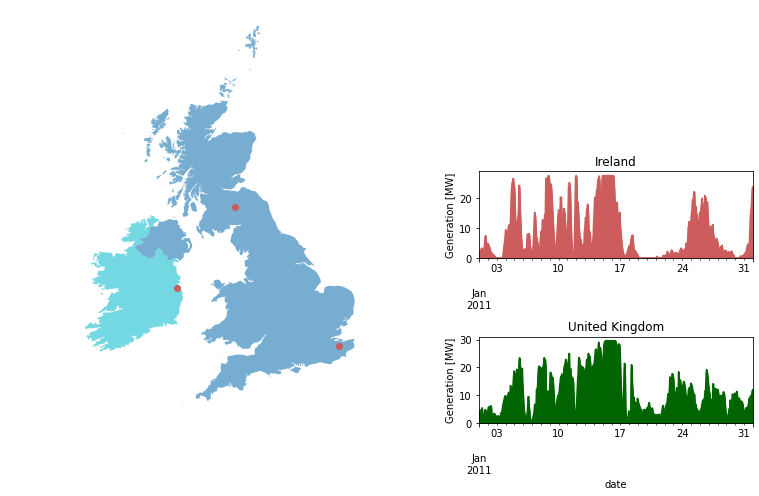

In [9]:
from shapely.geometry import Point

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
df = gpd.GeoDataFrame(UkIr, columns=['geometry']).assign(color=['1', '2'])
df.plot(column='color', ax=ax, zorder=1, transform=plate(), alpha=0.6)

sites.assign(geometry=sites.apply(lambda ds: Point(ds.x, ds.y), axis=1)
             ).plot(ax=ax, zorder=2, transform=plate(), color='indianred')

ax.outline_patch.set_edgecolor('white')

power_generation = cutout.wind('Vestas_V112_3MW', layout=layout.fillna(0), shapes=UkIr
                               ).to_pandas().rename_axis(index='', columns='shapes')

ax1 = fig.add_subplot(gs[1, 2])
power_generation['Ireland'].plot.area(
    ax=ax1, title='Ireland', color='indianred')
ax2 = fig.add_subplot(gs[2, 2])
power_generation['United Kingdom'].plot.area(
    ax=ax2, title='United Kingdom', color='darkgreen')

ax2.set_xlabel('date')
[ax.set_ylabel('Generation [MW]') for ax in [ax1,ax2]]

fig.tight_layout()

### Plot indicator matrix

* use [seaborn heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for plotting the indicator matrix of the United Kingdom shape

This indicator matrix is used to tell Atlite, which cells in the cutout represent the land area of the UK.

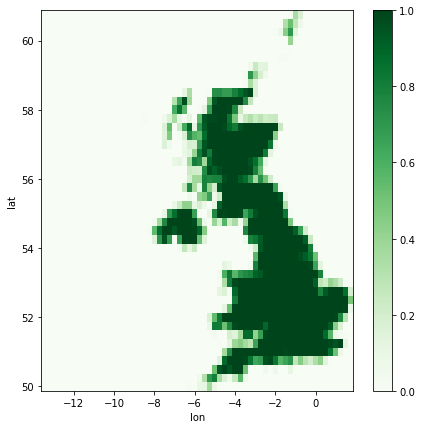

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
indicator_matrix_ir = cutout.indicatormatrix(UkIr)[0]

indicator_matrix_ir = xr.DataArray(indicator_matrix_ir.toarray().reshape(cutout.shape),
                                   dims=['lat','lon'],
                                   coords=[cutout.coords['lat'], cutout.coords['lon']])
indicator_matrix_ir.plot(cmap="Greens", ax=ax)